In [1]:
import dataset
import datetime
from datetime import timedelta
from parser import get_parser
import numpy as np 
import pandas as pd 
import torch
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt 
from utils import *
from pygData_util import *
import seaborn as sns
from utils import metrics
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from scipy.stats import pearsonr

In [2]:
sns.set_style("whitegrid")

In [3]:
data = dataset.Mdata(path='../../Custom-Semi-Supervised/data/mdata.csv')
parser = get_parser()
args = parser.parse_args(args=
                         ["--data","real-m", 
                          "--sampling","xgb",
                          "--train_from","20130101",
                          "--test_from","20160101",
                          "--test_length","365",
                          "--valid_length","90",
                          "--initial_inspection_rate", "5",
                         ])

In [4]:
# args
seed = args.seed
initial_inspection_rate = args.initial_inspection_rate
inspection_rate_option = args.inspection_plan
train_begin = args.train_from 
test_begin = args.test_from
test_length = args.test_length
valid_length = args.valid_length
chosen_data = args.data
numWeeks = args.numweeks

# Initial dataset split
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Initial dataset split
train_start_day = datetime.date(int(train_begin[:4]), int(train_begin[4:6]), int(train_begin[6:8]))
test_start_day = datetime.date(int(test_begin[:4]), int(test_begin[4:6]), int(test_begin[6:8]))
test_length = timedelta(days=test_length)    
test_end_day = test_start_day + test_length
valid_length = timedelta(days=valid_length)
valid_start_day = test_start_day - valid_length

# data
data.split(train_start_day, valid_start_day, test_start_day, test_end_day, valid_length, test_length, args)
data.featureEngineering()

Data size:
Train labeled: (14639, 46), Train unlabeled: (278142, 46), Valid labeled: (27043, 46), Valid unlabeled: (0, 17), Test: (99775, 46)
Checking label distribution
Training: 0.017374383209396067
Validation: 0.02486072687308144
Testing: 0.01153725275505135


In [5]:
categories=["importer.id","HS6"]
gdata = GraphData(data,use_xgb=False, categories=categories)

In [6]:
# obtain DATE prediction
DATE_prediction = pd.read_csv("inductive/Mdata_5.0%_prediction.csv").values.ravel()
GNN_prediction = pd.read_csv("inductive/fullmodel_results/GNN_real-m_5.0_prediction.csv").values.ravel()
r, p_value = pearsonr(DATE_prediction,GNN_prediction)
print("Correlation:%.4f" % r)

# overall stats
print("GNN results...")
gnn_result = metrics(GNN_prediction, data.test_cls_label, data.test_reg_label,None)
print("-"*50)
print("DATE results...")
DATE_result = metrics(DATE_prediction, data.test_cls_label, data.test_reg_label,None)

Correlation:0.3123
GNN results...
Checking top 1% suspicious transactions: 996
Precision: 0.0914, Recall: 0.0800, Revenue: 0.0757
Checking top 2% suspicious transactions: 1995
Precision: 0.0607, Recall: 0.1063, Revenue: 0.0881
Checking top 5% suspicious transactions: 4989
Precision: 0.0365, Recall: 0.1599, Revenue: 0.1767
Checking top 10% suspicious transactions: 9978
Precision: 0.0263, Recall: 0.2302, Revenue: 0.2920
--------------------------------------------------
DATE results...
Checking top 1% suspicious transactions: 998
Precision: 0.1443, Recall: 0.1265, Revenue: 0.1721
Checking top 2% suspicious transactions: 1987
Precision: 0.1007, Recall: 0.1757, Revenue: 0.2386
Checking top 5% suspicious transactions: 4989
Precision: 0.0641, Recall: 0.2812, Revenue: 0.3211
Checking top 10% suspicious transactions: 9978
Precision: 0.0527, Recall: 0.4622, Revenue: 0.5324


### Average unseen category 
In the following cell, I calculate the ratio of unseen importer/hs in test data.<br>
* Although there are lots of new importers, they only account for a small protion.
* However, in N data, the unseen importer took a large protion in test data.

Since DATE learns **unique embeddings** for importer/hs, we should expect **DATE perform well when the unseen rate is low.**

In [7]:
print("[valid] Unseen importer rate: %.4f" % (1 - gdata.valid_user.nonzero().shape[0] / data.valid.shape[0]))
print("[Valid] Unseen HS code rate: %.4f" % (1 - gdata.valid_item.nonzero().shape[0] / data.valid.shape[0]))
print("[test] Unseen importer rate: %.4f" % (1 - gdata.test_user.nonzero().shape[0] / data.test.shape[0]))
print("[test] Unseen HS code rate: %.4f" % (1 - gdata.test_item.nonzero().shape[0] / data.test.shape[0]))

[valid] Unseen importer rate: 0.2818
[Valid] Unseen HS code rate: 0.0204
[test] Unseen importer rate: 0.2852
[test] Unseen HS code rate: 0.0267


## Prediction Analysis
Here I would like to present some analysis of predictions made by DATE and GNN model.<br>
The flow of analysis is presented as follows:
1. Overall evaluation result. (just for reference to let you know which is performing better)
2. Correlation of predictions on illicit transaction.
3. Evaluating precision/recall in different subgroups.
4. Comparing the distribution in different subgroups.

### Importer Analysis
Calculate the frequency of importers appraning in the training set.<br>
Note that interval **\[0,1)** denotes the new importer, i.e. the frequency appearing in training set is 0. <br>
* In the **top-right figure**, the majority of transactions are maed by importers that lies in subgroup [10,50).
* The **bottom-right figure** shows that the new importers have the highest illicit rate, but the # transactions of new importers is small. <br>
Therefore, having a high illicit rate might not be help for overall prediction.

===============Evaluating subgroup:[0.0, 1.0)===============
GNN Results...
Checking top 1% suspicious transactions: 285
Precision: 0.1053, Recall: 0.0349, Revenue: 0.0493
Checking top 2% suspicious transactions: 570
Precision: 0.0737, Recall: 0.0489, Revenue: 0.0571
Checking top 5% suspicious transactions: 1423
Precision: 0.0506, Recall: 0.0838, Revenue: 0.1174
Checking top 10% suspicious transactions: 2846
Precision: 0.0383, Recall: 0.1269, Revenue: 0.1719
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 285
Precision: 0.2246, Recall: 0.0745, Revenue: 0.1292
Checking top 2% suspicious transactions: 570
Precision: 0.2140, Recall: 0.1420, Revenue: 0.2070
Checking top 5% suspicious transactions: 1423
Precision: 0.1202, Recall: 0.1991, Revenue: 0.2960
Checking top 10% suspicious transactions: 2846
Precision: 0.0833, Recall: 0.2759, Revenue: 0.3550


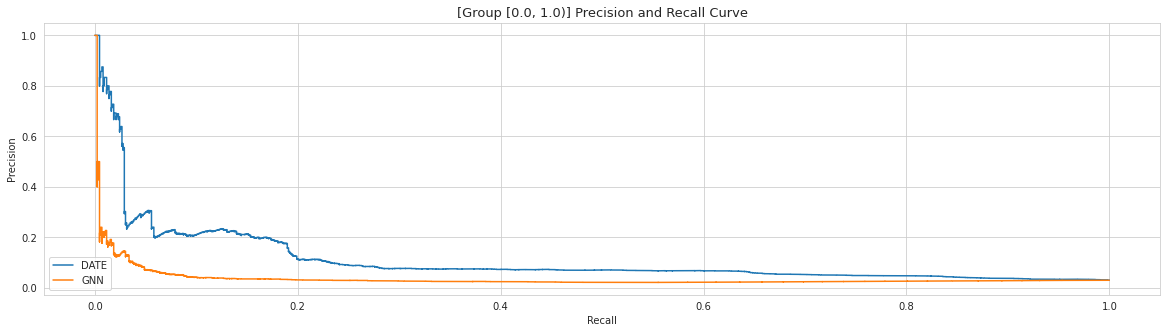

===============Evaluating subgroup:[1.0, 10.0)===============
GNN Results...
Checking top 1% suspicious transactions: 225
Precision: 0.0889, Recall: 0.1053, Revenue: 0.0713
Checking top 2% suspicious transactions: 449
Precision: 0.0646, Recall: 0.1526, Revenue: 0.1109
Checking top 5% suspicious transactions: 1124
Precision: 0.0374, Recall: 0.2211, Revenue: 0.2218
Checking top 10% suspicious transactions: 2248
Precision: 0.0258, Recall: 0.3053, Revenue: 0.3069
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 225
Precision: 0.0844, Recall: 0.1000, Revenue: 0.0911
Checking top 2% suspicious transactions: 450
Precision: 0.0556, Recall: 0.1316, Revenue: 0.1367
Checking top 5% suspicious transactions: 1124
Precision: 0.0329, Recall: 0.1947, Revenue: 0.2265
Checking top 10% suspicious transactions: 2248
Precision: 0.0240, Recall: 0.2842, Revenue: 0.3742


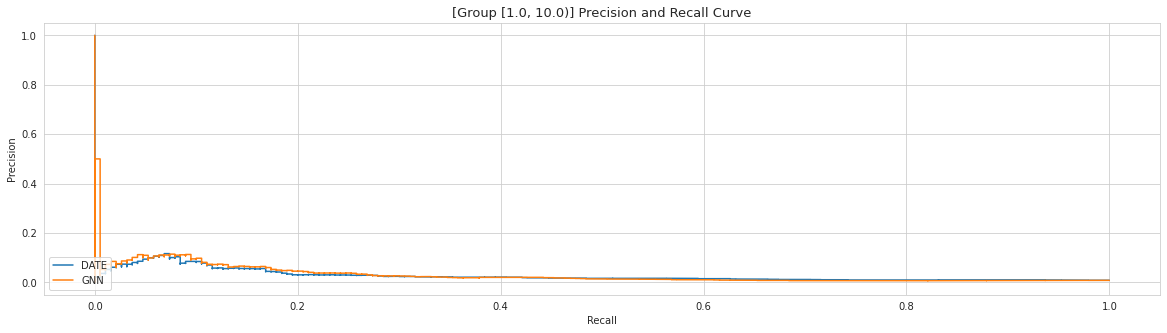

===============Evaluating subgroup:[10.0, 50.0)===============
GNN Results...
Checking top 1% suspicious transactions: 140
Precision: 0.0286, Recall: 0.1111, Revenue: 0.0494
Checking top 2% suspicious transactions: 281
Precision: 0.0178, Recall: 0.1389, Revenue: 0.0495
Checking top 5% suspicious transactions: 629
Precision: 0.0127, Recall: 0.2222, Revenue: 0.3581
Checking top 10% suspicious transactions: 1401
Precision: 0.0093, Recall: 0.3611, Revenue: 0.5288
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 141
Precision: 0.0071, Recall: 0.0278, Revenue: 0.0146
Checking top 2% suspicious transactions: 281
Precision: 0.0036, Recall: 0.0278, Revenue: 0.0146
Checking top 5% suspicious transactions: 701
Precision: 0.0043, Recall: 0.0833, Revenue: 0.1342
Checking top 10% suspicious transactions: 1402
Precision: 0.0064, Recall: 0.2500, Revenue: 0.2227


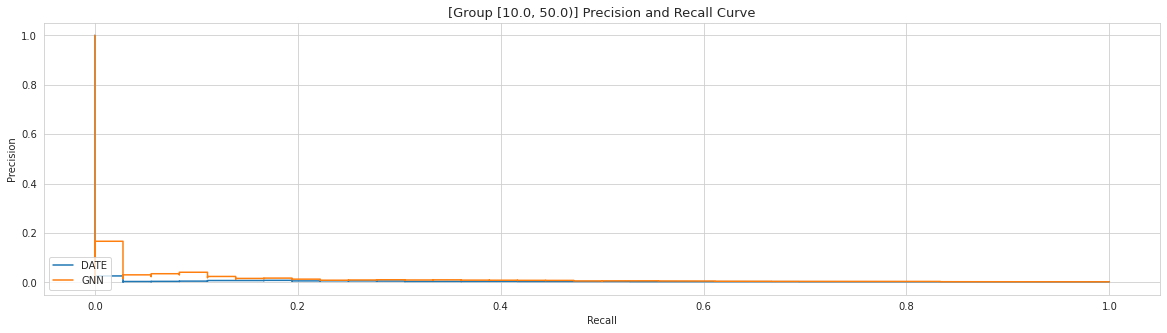

===============Evaluating subgroup:[50.0, 100.0)===============
GNN Results...
Checking top 1% suspicious transactions: 29
Precision: 0.0345, Recall: 0.1667, Revenue: 0.0613
Checking top 2% suspicious transactions: 29
Precision: 0.0345, Recall: 0.1667, Revenue: 0.0613
Checking top 5% suspicious transactions: 219
Precision: 0.0091, Recall: 0.3333, Revenue: 0.0837
Checking top 10% suspicious transactions: 516
Precision: 0.0058, Recall: 0.5000, Revenue: 0.0891
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 52
Precision: 0.0000, Recall: 0.0000, Revenue: 0.0000
Checking top 2% suspicious transactions: 104
Precision: 0.0000, Recall: 0.0000, Revenue: 0.0000
Checking top 5% suspicious transactions: 257
Precision: 0.0078, Recall: 0.3333, Revenue: 0.4040
Checking top 10% suspicious transactions: 518
Precision: 0.0039, Recall: 0.3333, Revenue: 0.4040


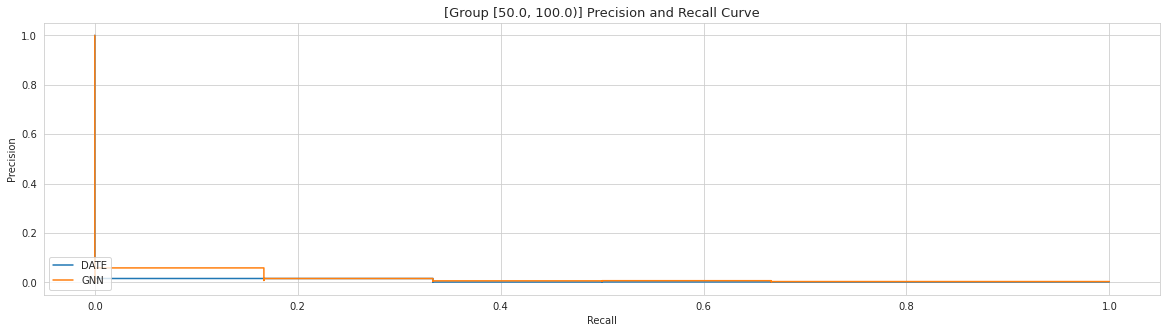

===============Evaluating subgroup:[100.0, 200.0)===============
GNN Results...
Checking top 1% suspicious transactions: 45
Precision: 0.0444, Recall: 0.1667, Revenue: 0.2849
Checking top 2% suspicious transactions: 87
Precision: 0.0345, Recall: 0.2500, Revenue: 0.2849
Checking top 5% suspicious transactions: 221
Precision: 0.0136, Recall: 0.2500, Revenue: 0.2849
Checking top 10% suspicious transactions: 442
Precision: 0.0181, Recall: 0.6667, Revenue: 0.6423
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 44
Precision: 0.0227, Recall: 0.0833, Revenue: 0.2842
Checking top 2% suspicious transactions: 89
Precision: 0.0225, Recall: 0.1667, Revenue: 0.2849
Checking top 5% suspicious transactions: 217
Precision: 0.0138, Recall: 0.2500, Revenue: 0.2849
Checking top 10% suspicious transactions: 440
Precision: 0.0068, Recall: 0.2500, Revenue: 0.2849


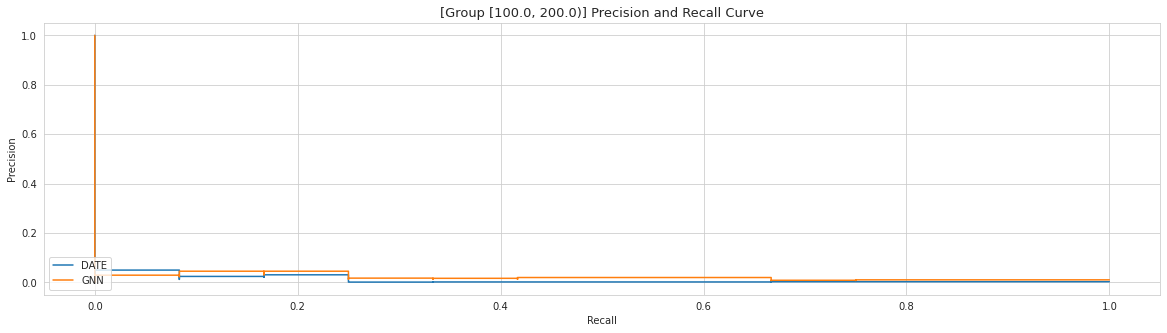

===============Evaluating subgroup:[200.0, 500.0)===============
GNN Results...


ZeroDivisionError: division by zero

In [8]:
# calculate the frequency of importer of test transaction appearing in training set
cnter = Counter(gdata.train_user.numpy())
test_counts = [cnter.get(i,0) for i in gdata.test_user.numpy()]
count_Ser = pd.Series(test_counts)
train_counts = [cnter.get(i,0) for i in gdata.train_user.numpy()]
train_Ser = pd.Series(train_counts)

# plot training data for reference
bins = [0, 1,10,50,100,200,500,np.inf]
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1,2,1)
# cuteted_bin = pd.cut(train_Ser,bins, include_lowest=True, right=False).value_counts()
# cuteted_bin.plot(kind="bar",ax=ax1)
# plt.title("[Train] Frequency of importer appearing in the training set")
# plt.ylabel("# transaction")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)

# plot 
# ax2 = fig.add_subplot(1,2,2)
# cuteted_bin = pd.cut(count_Ser,bins, include_lowest=True, right=False).value_counts()
# cuteted_bin.plot(kind="bar",ax=ax2)
# plt.title("[Test] Frequency of importer appearing in the training set")
# plt.ylabel("# transaction")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)
# plt.show()

### illicit rate among different subgroup ###

# train
train_bins = pd.cut(train_Ser,bins, include_lowest=True, right=False)
train_label = pd.Series(data.train_cls_label)
train_summary = pd.concat([train_bins,train_label],axis=1)
train_summary.columns = ["bin","illicit"]

# test
test_bins = pd.cut(count_Ser,bins, include_lowest=True, right=False)
test_label = pd.Series(data.test_cls_label)
test_summary = pd.concat([test_bins,test_label],axis=1)
test_summary.columns = ["bin","illicit"]

#--------- plots for analysis-----------------
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1,2,1)
# plt.xticks(rotation=30)
# train_summary = train_summary.groupby("bin").mean().sort_values("illicit",ascending=False)
# train_summary.plot(kind="bar",ax=ax1)
# plt.title("[Train] Illicit rate among different subgroup")
# plt.ylabel("illicit rate")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)
# ax2 = fig.add_subplot(1,2,2)
# test_summary = test_summary.groupby("bin").mean().sort_values("illicit",ascending=False)
# test_summary.plot(kind="bar",ax=ax2)
# plt.title("[Test] Illicit rate among different subgroup")
# plt.ylabel("illicit rate")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)
# plt.show()

# ----------prediction analysis--------------
analysis = pd.DataFrame({"bins":test_bins.values, \
                             "gnn":GNN_prediction, "DATE":DATE_prediction, \
                             "cls_label":data.test_cls_label, "rev_label": data.test_reg_label})
for groupID, subgroup in analysis.groupby("bins"):
    print("="*15+"Evaluating subgroup:%s" % groupID + "="*15)
    # metrics
    print("GNN Results...")
    metrics(subgroup["gnn"],subgroup["cls_label"],subgroup["rev_label"],None)
    print("-"*40)
    print("DATE Results...")
    metrics(subgroup["DATE"],subgroup["cls_label"],subgroup["rev_label"],None)
    # plots
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(1,1,1)
    precision, recall, _ = precision_recall_curve(subgroup["cls_label"], subgroup["DATE"],pos_label=1)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot(name = "DATE",ax=ax)
    precision, recall, _ = precision_recall_curve(subgroup["cls_label"], subgroup["gnn"],pos_label=1)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot(name = "GNN",ax=ax)
    plt.title("[Group %s] Precision and Recall Curve" % groupID, fontsize=13)
    plt.show()

### HS code Analysis

In [ ]:
# calculate the frequency of importer of test transaction appearing in training set
cnter = Counter(gdata.train_item.numpy())
test_counts = [cnter.get(i,0) for i in gdata.test_item.numpy()]
count_Ser = pd.Series(test_counts)
train_counts = [cnter.get(i,0) for i in gdata.train_item.numpy()]
train_Ser = pd.Series(train_counts)

# plot training data for reference
bins = [0, 1,10,50,100,200,500,np.inf]
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1,2,1)
# cuteted_bin = pd.cut(train_Ser,bins, include_lowest=True, right=False).value_counts()
# cuteted_bin.plot(kind="bar",ax=ax1)
# plt.title("[Train] Frequency of HSCode appearing in the training set")
# plt.ylabel("# transaction")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)

# # plot 
# ax2 = fig.add_subplot(1,2,2)
# cuteted_bin = pd.cut(count_Ser,bins, include_lowest=True, right=False).value_counts()
# cuteted_bin.plot(kind="bar",ax=ax2)
# plt.title("[Test] Frequency of HSCode appearing in the training set")
# plt.ylabel("# transaction")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)
# plt.show()

### illicit rate among different subgroup ###

# train
train_bins = pd.cut(train_Ser,bins, include_lowest=True, right=False)
train_label = pd.Series(data.train_cls_label)
train_summary = pd.concat([train_bins,train_label],axis=1)
train_summary.columns = ["bin","illicit"]

# test
test_bins = pd.cut(count_Ser,bins, include_lowest=True, right=False)
test_label = pd.Series(data.test_cls_label)
test_summary = pd.concat([test_bins,test_label],axis=1)
test_summary.columns = ["bin","illicit"]

# ----------plots for analysis--------------
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1,2,1)
# plt.xticks(rotation=30)
# train_summary = train_summary.groupby("bin").mean().sort_values("illicit",ascending=False)
# train_summary.plot(kind="bar",ax=ax1)
# plt.title("[Train] Illicit rate among different subgroup")
# plt.ylabel("illicit rate")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)
# ax2 = fig.add_subplot(1,2,2)
# test_summary = test_summary.groupby("bin").mean().sort_values("illicit",ascending=False)
# test_summary.plot(kind="bar",ax=ax2)
# plt.title("[Test] Illicit rate among different subgroup")
# plt.ylabel("illicit rate")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)
# plt.show()

# ----------prediction analysis--------------
analysis = pd.DataFrame({"bins":test_bins.values, \
                             "gnn":GNN_prediction, "DATE":DATE_prediction, \
                             "cls_label":data.test_cls_label, "rev_label": data.test_reg_label})
for groupID, subgroup in analysis.groupby("bins"):
    print("="*15+"Evaluating subgroup:%s" % groupID + "="*15)
    # metrics
    print("GNN Results...")
    metrics(subgroup["gnn"],subgroup["cls_label"],subgroup["rev_label"],None)
    print("-"*40)
    print("DATE Results...")
    metrics(subgroup["DATE"],subgroup["cls_label"],subgroup["rev_label"],None)
    # plots
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(1,1,1)
    precision, recall, _ = precision_recall_curve(subgroup["cls_label"], subgroup["DATE"],pos_label=1)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot(name = "DATE",ax=ax)
    precision, recall, _ = precision_recall_curve(subgroup["cls_label"], subgroup["gnn"],pos_label=1)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot(name = "GNN",ax=ax)
    plt.title("[Group %s] Precision and Recall Curve" % groupID, fontsize=13)
    plt.show()